In [1]:
import gempyor # incidCshift_delta_R13
from gempyor import seir, config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob, os, sys
from pathlib import Path

# import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click

import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

class RunInfo():
    def __init__(self, run_id, config_path=None, folder_path=None):
        self.run_id = run_id
        self.config_path = config_path
        self.folder_path = folder_path



## From Slack messages

In [2]:
csp_prod_messages = [
"""
SMH R16 highBoo_modVar
Setting number of output slots to 300 [via config file]
Setting sims per job to 55 [estimated based on 52 geoids and 300 simulations_per_slot in config]
Setting number of blocks to 6 [via math]
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
Launching USA-20221115T043444_inference_med...
Resuming from run id is FCH_R15_lateBoo_Var_ContRes_blk5_fch_Nov6_pertBA45 located in s3://idd-inference-runs/USA-20221101Level5
Final output will be: s3://idd-inference-runs/USA-20221115T043444/model_output/
Run id is SMH_R16_highBoo_modVar_ContRes_blk4_tsvacc
Switched to a new branch 'run_USA-20221115T043444'
config_SMH_R16_highBoo_modVar_ContRes_blk4_tsvacc.yml
""",
"""
SMH R16 lowBoo_modVar
Setting number of output slots to 300 [via config file]
Setting sims per job to 55 [estimated based on 52 geoids and 300 simulations_per_slot in config]
Setting number of blocks to 6 [via math]
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
Launching USA-20221115T045744_inference_med...
Resuming from run id is FCH_R15_lateBoo_Var_ContRes_blk5_fch_Nov6_pertBA45 located in s3://idd-inference-runs/USA-20221101Level5
Final output will be: s3://idd-inference-runs/USA-20221115T045744/model_output/
Run id is SMH_R16_lowBoo_modVar_ContRes_blk4_tsvacc
Switched to a new branch 'run_USA-20221115T045744'
config_SMH_R16_lowBoo_modVar_ContRes_blk4_tsvacc.yml
""",
"""
SMH R16 highBoo_highVar
Setting number of output slots to 300 [via config file]
Setting sims per job to 55 [estimated based on 52 geoids and 300 simulations_per_slot in config]
Setting number of blocks to 6 [via math]
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
Launching USA-20221115T051341_inference_med...
Resuming from run id is FCH_R15_lateBoo_Var_ContRes_blk5_fch_Nov6_pertBA45 located in s3://idd-inference-runs/USA-20221101Level67
Final output will be: s3://idd-inference-runs/USA-20221115T051341/model_output/
Run id is SMH_R16_highBoo_highVar_ContRes_blk4_tsvacc
Switched to a new branch 'run_USA-20221115T051341'
config_SMH_R16_highBoo_highVar_ContRes_blk4_tsvacc.yml
""",
"""
SMH R16 lowBoo_highVar
Setting number of output slots to 300 [via config file]
Setting sims per job to 55 [estimated based on 52 geoids and 300 simulations_per_slot in config]
Setting number of blocks to 6 [via math]
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
Launching USA-20221115T053437_inference_med...
Resuming from run id is FCH_R15_lateBoo_Var_ContRes_blk5_fch_Nov6_pertBA45 located in s3://idd-inference-runs/USA-20221101Level67
Final output will be: s3://idd-inference-runs/USA-20221115T053437/model_output/
Run id is SMH_R16_lowBoo_highVar_ContRes_blk4_tsvacc
Switched to a new branch 'run_USA-20221115T053437'
config_SMH_R16_lowBoo_highVar_ContRes_blk4_tsvacc.yml
"""]

all_runs = {}
import re
for mes in csp_prod_messages:
    run_id = re.findall(r'Run id is (?P<min>.*)', mes)[0]
    config_path = re.findall(r'(?P<min>.*).yml', mes)[0] + ".yml"
    print(f"found run {run_id} with config {config_path}")
    all_runs[run_id] = RunInfo(run_id, config_path=config_path, folder_path=f"s3pull/{run_id}")

## Manually

In [7]:
all_runs = {
    'highVE_pesImm': RunInfo('highVE_pesImm', 'config_SMH_R2_highVE_pesImm_2022_trunc.yml'),
    'lowVE_pesImm': RunInfo('lowVE_pesImm', 'config_SMH_R2_lowVE_pesImm_2022_trunc.yml')
}

In [8]:
for run_name, run_info in all_runs.items():
    run_id = run_info.run_id
    config_filepath = run_info.config_path
    run_info.gempyor_simulator = gempyor.InferenceSimulator(
        config_path=config_filepath,
        run_id="SMH_R14_restBoo_noVar_blk5",
        #prefix=f"USA/inference/med/{run_id}/global/intermediate/000000001.",
        first_sim_index=1,
        scenario="inference",  # NPIs scenario to use
        deathrate="med",  # Outcome scenario to use
        stoch_traj_flag=False,
        spatial_path_prefix="./",  # prefix where to find the folder indicated in spatial_setup$
)

  gempyor >> Running ***DETERMINISTIC*** simulation;
  gempyor >> Setup USA_inference; index: 1; run_id: SMH_R14_restBoo_noVar_blk5,
  gempyor >> prefix: test_prefix;
  gempyor >> Running ***DETERMINISTIC*** simulation;
  gempyor >> Setup USA_inference; index: 1; run_id: SMH_R14_restBoo_noVar_blk5,
  gempyor >> prefix: test_prefix;


## Analyse SEIR from files

In [79]:
def get_all_files(file_type):
    if file_type=="seed":
        ext="csv"
    else:
        ext="parquet"
    files = {}
    for run_name, run_info in all_runs.items():
        l = []
        for f in Path(str(run_info.folder_path)).rglob(f'*.{ext}'):
            if file_type in str(f):
                l.append(str(f))
        files[run_name] = l
    return files

seir_files = get_all_files("seir")

In [54]:
all_runs.keys()

dict_keys(['SMH_R16_highBoo_modVar_ContRes_blk4_tsvacc', 'SMH_R16_lowBoo_modVar_ContRes_blk4_tsvacc', 'SMH_R16_highBoo_highVar_ContRes_blk4_tsvacc', 'SMH_R16_lowBoo_highVar_ContRes_blk4_tsvacc'])

In [58]:
out_df = seir_files[list(all_runs.keys())[0]][0]
out_df = gempyor.read_df(out_df)

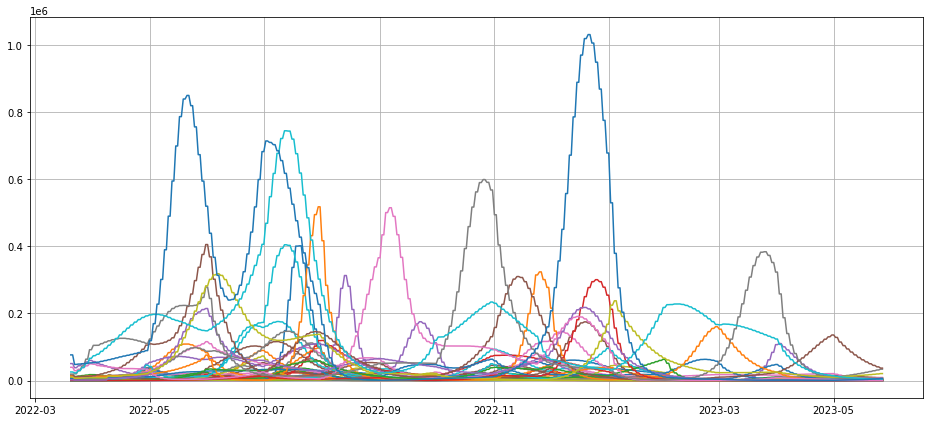

In [61]:
comp_to_plot = "I1" #["S", "E", "I1", "I2", "I3", "R", "W"] 
vt= 'incidence'
all_S = out_df[(out_df['mc_value_type'] == vt) & (out_df['mc_infection_stage'] == comp_to_plot)].reset_index(drop=True).groupby('date').sum()
fig, ax = plt.subplots(1,1, figsize=(16,7))
ax.plot(all_S)
ax.grid()

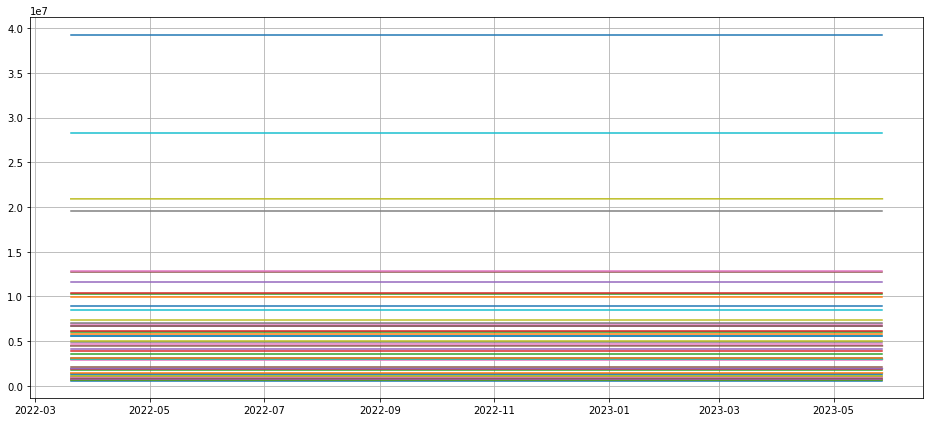

In [65]:
#plot poppulation per state:
all_S = out_df[(out_df['mc_value_type'] == 'prevalence')].reset_index(drop=True).groupby('date').sum()


fig, ax = plt.subplots(1,1, figsize=(16,7))
ax.plot(all_S)

ax.grid()

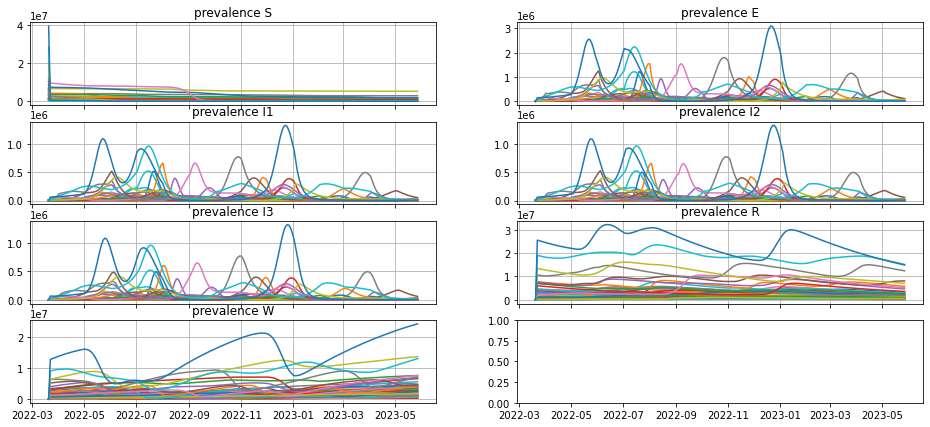

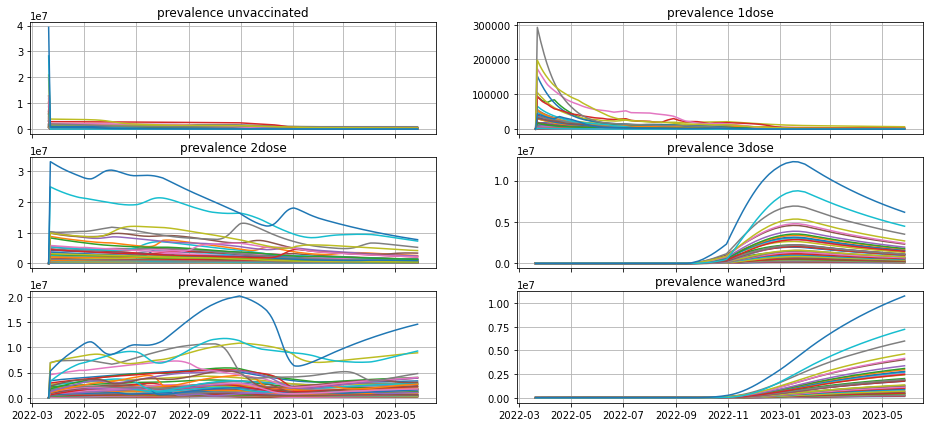

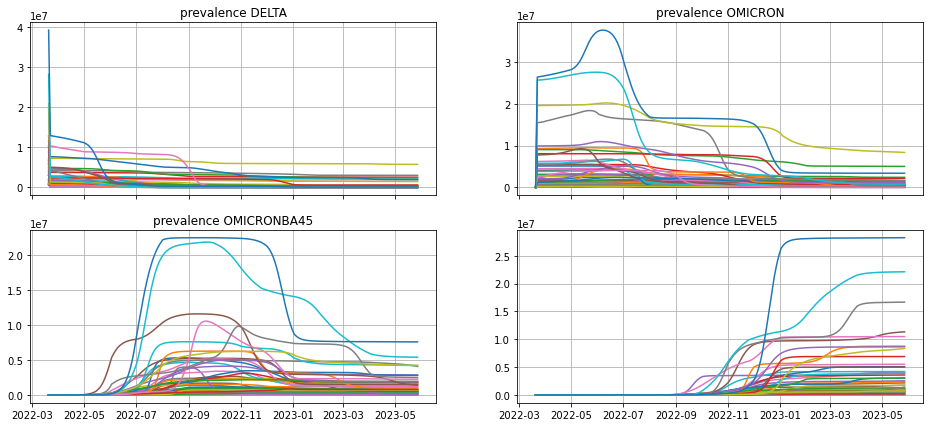

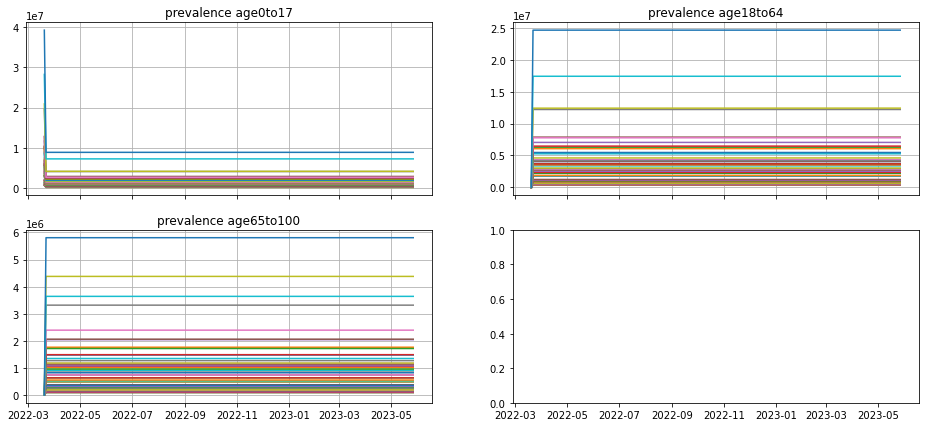

In [66]:
vt= 'prevalence'
mc_to_plot = 'mc_vaccination_stage'

for mc_to_plot in [mc_tp for mc_tp in out_df.columns if ('mc' in mc_tp and mc_tp != 'mc_name' and mc_tp != 'mc_value_type')]:

    fig, axes = plt.subplots(len(out_df[mc_to_plot].unique())//2+len(out_df[mc_to_plot].unique())%2,2, figsize=(16,7), sharex=True)

    for i, comp_to_plot in enumerate(out_df[mc_to_plot].unique()):
        ax = axes.flat[i]
        all_S = out_df[(out_df['mc_value_type'] == vt) & (out_df[mc_to_plot] == comp_to_plot)].reset_index(drop=True).groupby('date').sum()

        ax.plot(all_S)
        ax.grid()
        ax.set_title(f"{vt} {comp_to_plot}")

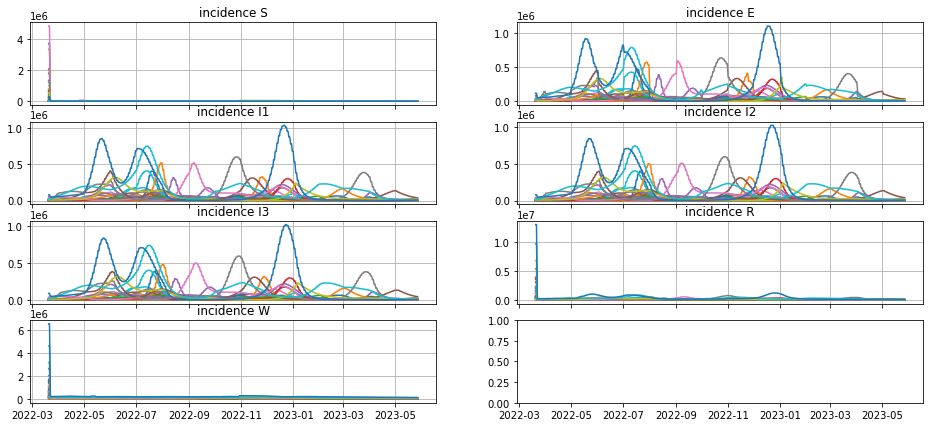

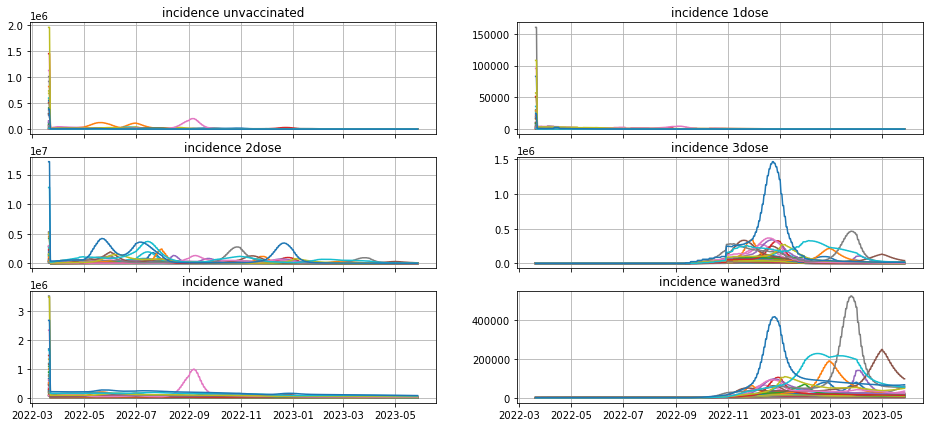

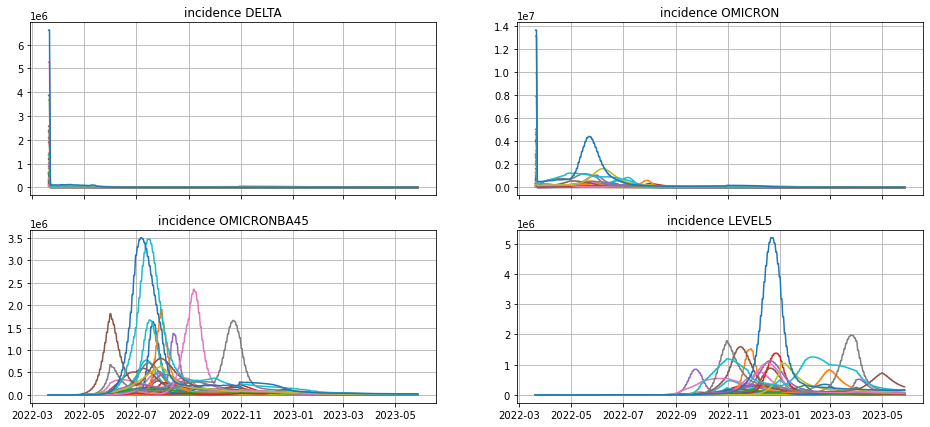

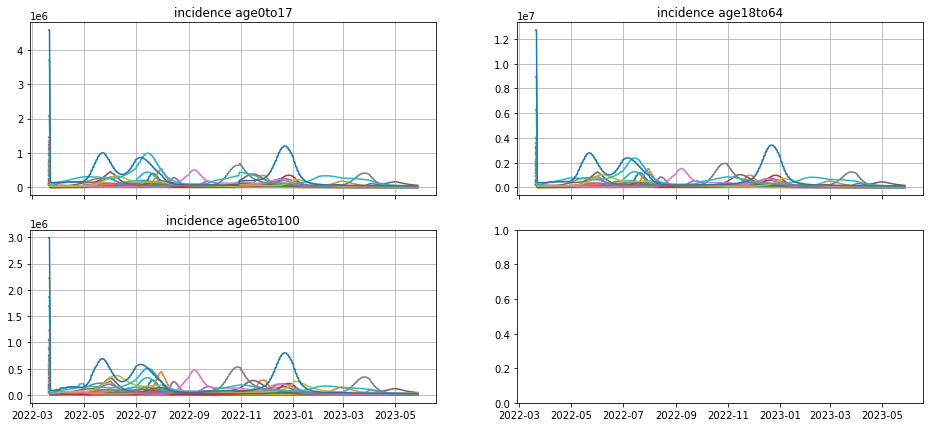

In [70]:
vt= 'incidence'
mc_to_plot = 'mc_vaccination_stage'

for mc_to_plot in [mc_tp for mc_tp in out_df.columns if ('mc' in mc_tp and mc_tp != 'mc_name' and mc_tp != 'mc_value_type')]:

    fig, axes = plt.subplots(len(out_df[mc_to_plot].unique())//2+len(out_df[mc_to_plot].unique())%2,2, figsize=(16,7), sharex=True)

    for i, comp_to_plot in enumerate(out_df[mc_to_plot].unique()):
        ax = axes.flat[i]
        all_S = out_df[(out_df['mc_value_type'] == vt) & (out_df[mc_to_plot] == comp_to_plot)].reset_index(drop=True).groupby('date').sum()

        ax.plot(all_S)
        ax.grid()
        ax.set_title(f"{vt} {comp_to_plot}")

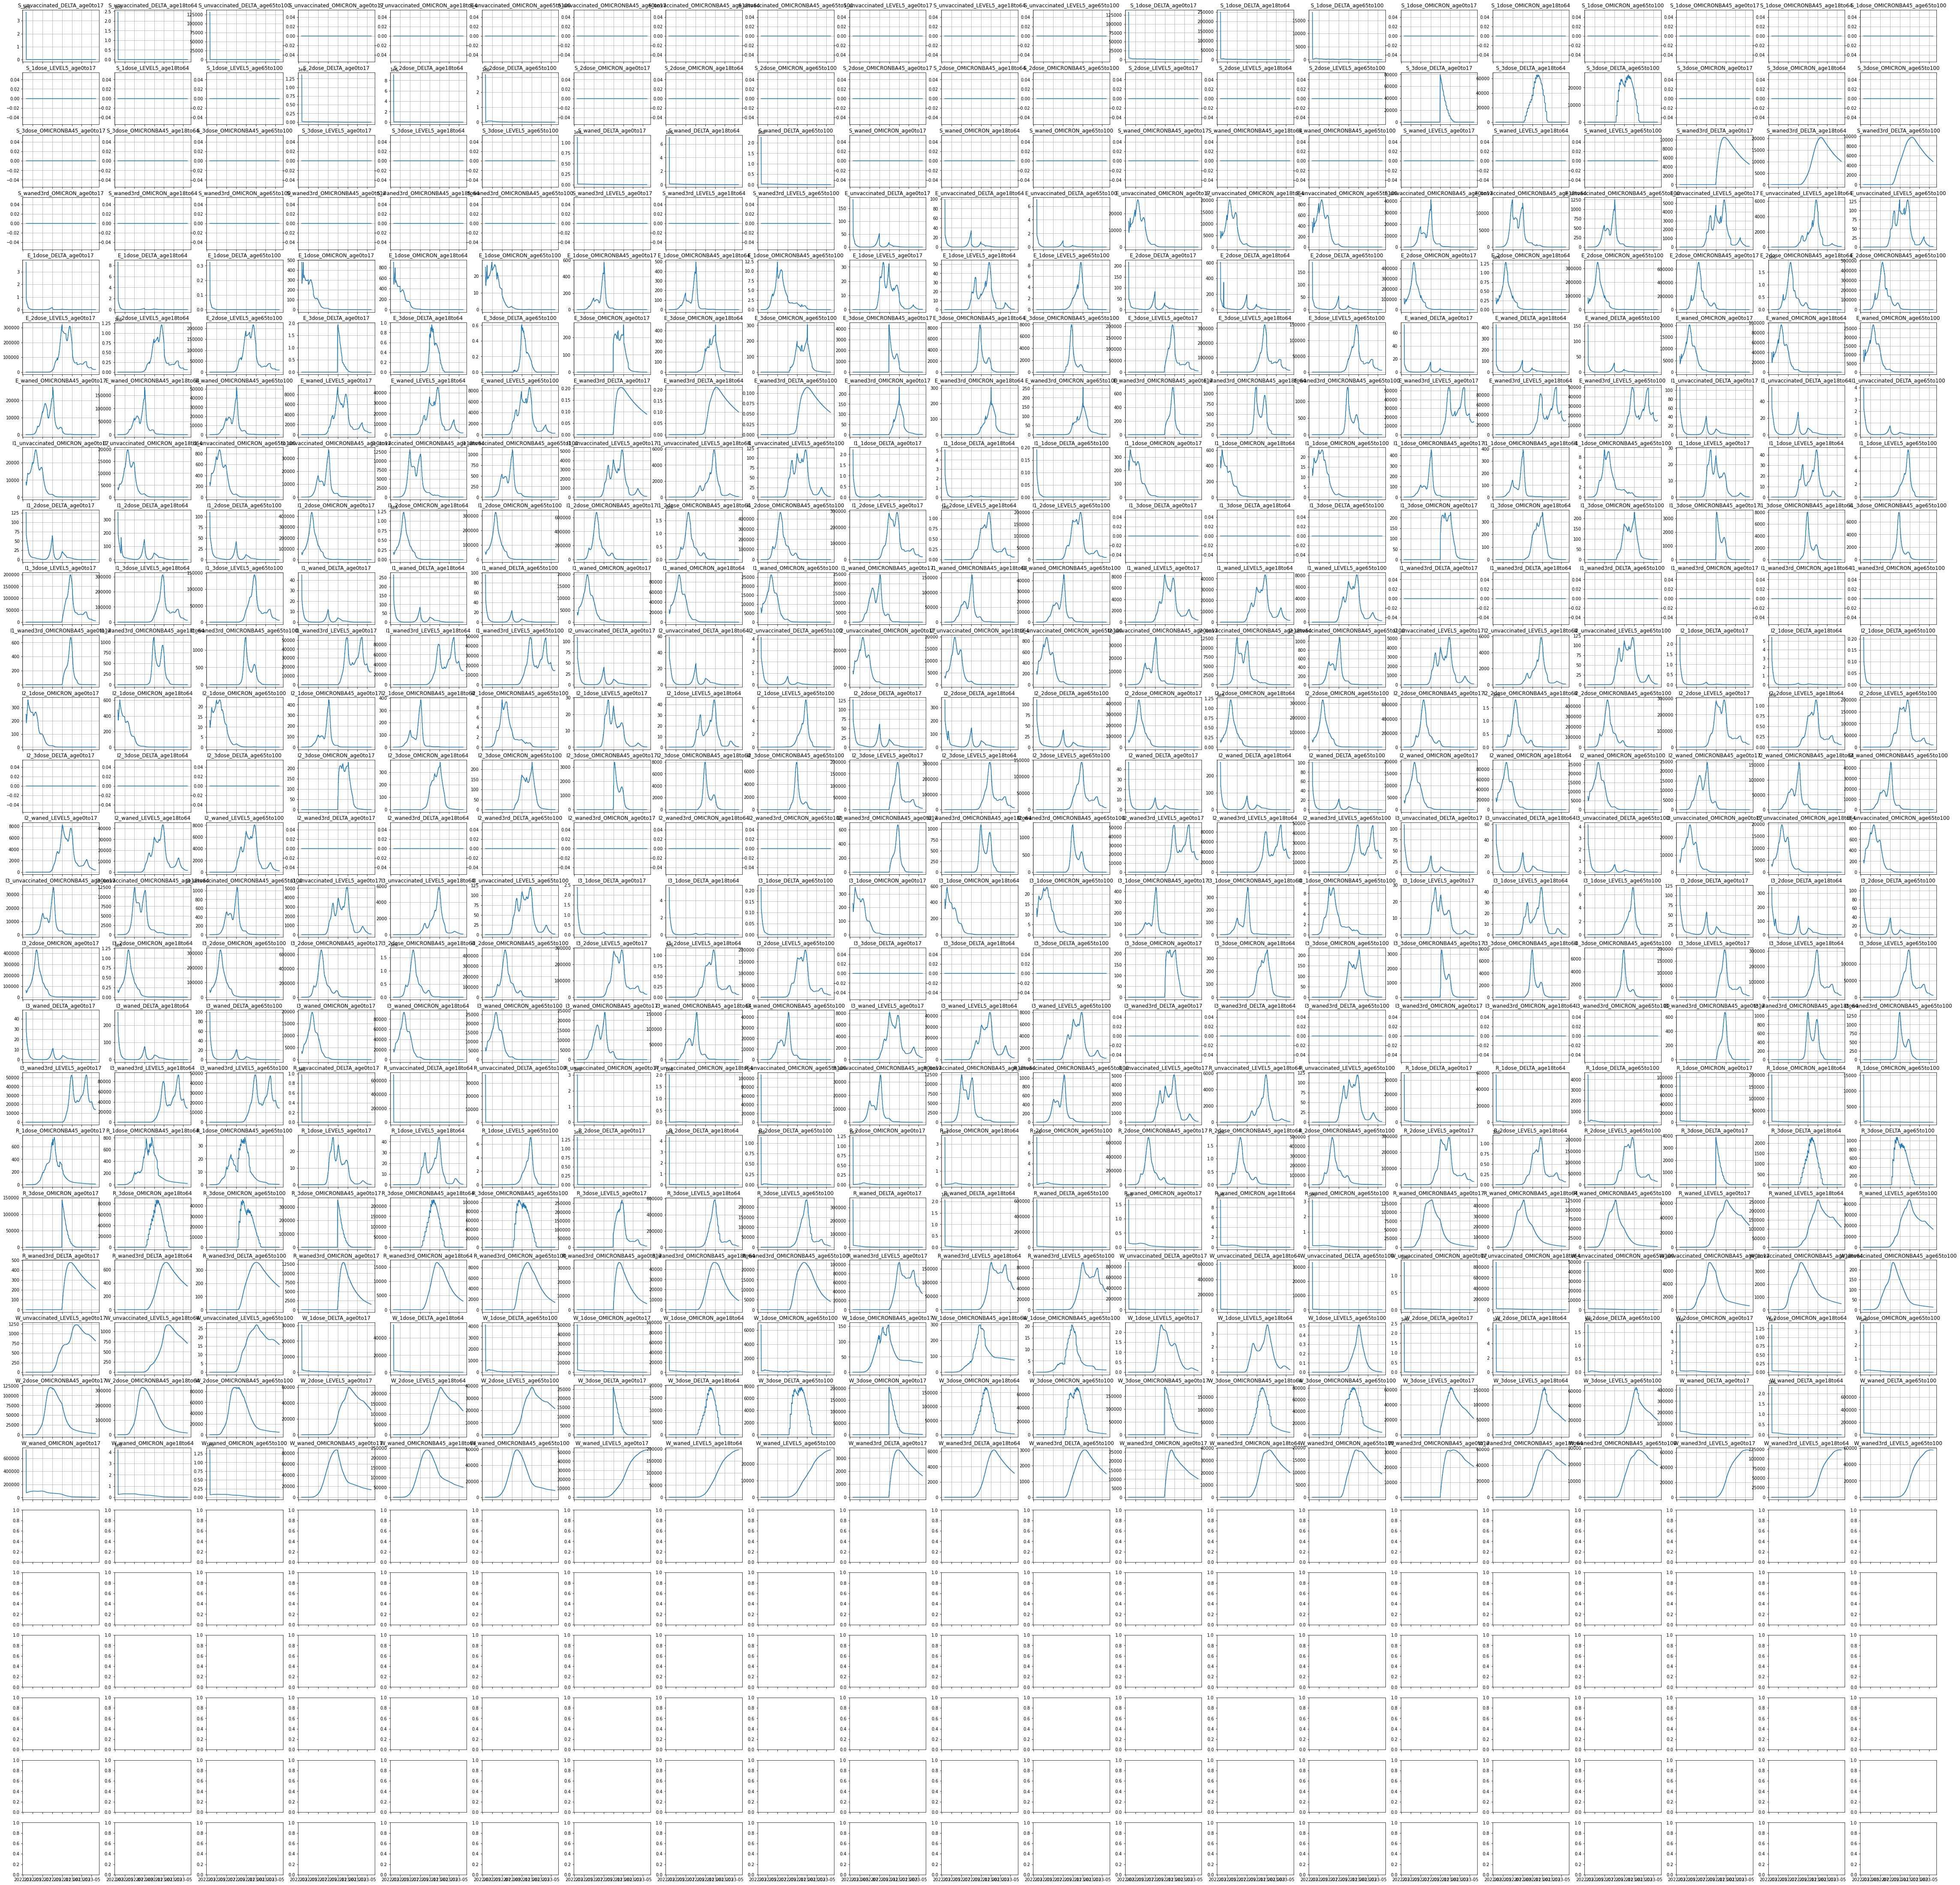

In [71]:
vt= 'incidence'
mc_to_plot = "mc_name"

fig, axes = plt.subplots(30,21,figsize=(80,80), sharex=True)

for i, comp_to_plot in enumerate(out_df[mc_to_plot].unique()):
    ax = axes.flat[i]
    all_S = out_df[(out_df['mc_value_type'] == vt) & (out_df[mc_to_plot] == comp_to_plot)].reset_index(drop=True).groupby('date').sum()

    ax.plot(all_S.sum(axis=1))
    ax.grid()
    ax.set_title(f"{comp_to_plot}")
plt.savefig(f"all_comp_{vt}.pdf")

## Analyse seed by files

In [80]:
seed_files = get_all_files("seed")

In [81]:
out_df = seed_files[list(all_runs.keys())[0]][0]
out_df = gempyor.read_df(out_df)

In [82]:
out_df

place                 date    amount source_infection_stage  \
0     56000  2022-03-20 00:00:00  0.000694                      S   
1     50000  2022-03-20 00:00:00  0.011099                      S   
2     11000  2022-03-20 00:00:00  0.000004                      S   
3      2000  2022-03-20 00:00:00  0.000013                      S   
4     38000  2022-03-20 00:00:00  0.000015                      S   
...     ...                  ...       ...                    ...   
9062  55000  2022-07-20 00:00:11  0.532100                      R   
9063  55000  2022-07-29 23:59:30  0.686594                      R   
9064  55000  2022-07-31 00:00:00  1.322600                      R   
9065  55000  2022-08-02 23:59:48  4.316957                      R   
9066  55000  2022-08-04 00:00:01  1.311387                      R   

     source_vaccination_stage source_variant_type source_age_strata  \
0                unvaccinated               DELTA          age0to17   
1                unvaccinated               DELTA          age0to17   
2                unvaccinated               DELTA          age0to17   
3                unvaccinated               DELTA          age0to17   
4                unvaccinated               DELTA          age0to17   
...                       ...                 ...               ...   
9062                    2dose             OMICRON         age18to64   
9063                    2dose             OMICRON         age18to64   
9064                    2dose             OMICRON         age18to64   
9065                    2dose             OMICRON         age18to64   
9066                    2dose             OMICRON         age18to64   

     destination_infection_stage destination_vaccination_stage  \
0                              E                         1dose   
1                              E                         1dose   
2                              E                         1dose   
3                              E                         1dose   
4                              E                         1dose   
...                          ...                           ...   
9062                           E                         2dose   
9063                           E                         2dose   
9064                           E                         2dose   
9065                           E                         2dose   
9066                           E                         2dose   

     destination_variant_type destination_age_strata  no_perturb  
0                       DELTA               age0to17        True  
1                       DELTA               age0to17        True  
2                       DELTA               age0to17        True  
3                       DELTA               age0to17        True  
4                       DELTA               age0to17        True  
...                       ...                    ...         ...  
9062                   LEVEL5              age18to64       False  
9063                   LEVEL5              age18to64       False  
9064                   LEVEL5              age18to64       False  
9065                   LEVEL5              age18to64       False  
9066                   LEVEL5              age18to64       False  

[9067 rows x 12 columns]

In [93]:
# unique variable across all files
unique_vars = []
for key, fn in seed_files.items():
    df = gempyor.read_df(fn[0])
    unique_vars.extend(list(df["destination_variant_type"].unique()))
unique_vars = set(unique_vars)

In [116]:
gempyor.read_df(fn[0])


place                 date    amount source_infection_stage  \
0     56000  2022-03-20 00:00:00  0.000694                      S   
1     50000  2022-03-20 00:00:00  0.011099                      S   
2     11000  2022-03-20 00:00:00  0.000004                      S   
3      2000  2022-03-20 00:00:00  0.000013                      S   
4     38000  2022-03-20 00:00:00  0.000015                      S   
...     ...                  ...       ...                    ...   
9062  55000  2022-07-20 00:00:11  0.532100                      R   
9063  55000  2022-07-29 23:59:30  0.686594                      R   
9064  55000  2022-07-31 00:00:00  1.322600                      R   
9065  55000  2022-08-02 23:59:48  4.316957                      R   
9066  55000  2022-08-04 00:00:01  1.311387                      R   

     source_vaccination_stage source_variant_type source_age_strata  \
0                unvaccinated               DELTA          age0to17   
1                unvaccinated               DELTA          age0to17   
2                unvaccinated               DELTA          age0to17   
3                unvaccinated               DELTA          age0to17   
4                unvaccinated               DELTA          age0to17   
...                       ...                 ...               ...   
9062                    2dose             OMICRON         age18to64   
9063                    2dose             OMICRON         age18to64   
9064                    2dose             OMICRON         age18to64   
9065                    2dose             OMICRON         age18to64   
9066                    2dose             OMICRON         age18to64   

     destination_infection_stage destination_vaccination_stage  \
0                              E                         1dose   
1                              E                         1dose   
2                              E                         1dose   
3                              E                         1dose   
4                              E                         1dose   
...                          ...                           ...   
9062                           E                         2dose   
9063                           E                         2dose   
9064                           E                         2dose   
9065                           E                         2dose   
9066                           E                         2dose   

     destination_variant_type destination_age_strata  no_perturb  
0                       DELTA               age0to17        True  
1                       DELTA               age0to17        True  
2                       DELTA               age0to17        True  
3                       DELTA               age0to17        True  
4                       DELTA               age0to17        True  
...                       ...                    ...         ...  
9062                   LEVEL5              age18to64       False  
9063                   LEVEL5              age18to64       False  
9064                   LEVEL5              age18to64       False  
9065                   LEVEL5              age18to64       False  
9066                   LEVEL5              age18to64       False  

[9067 rows x 12 columns]

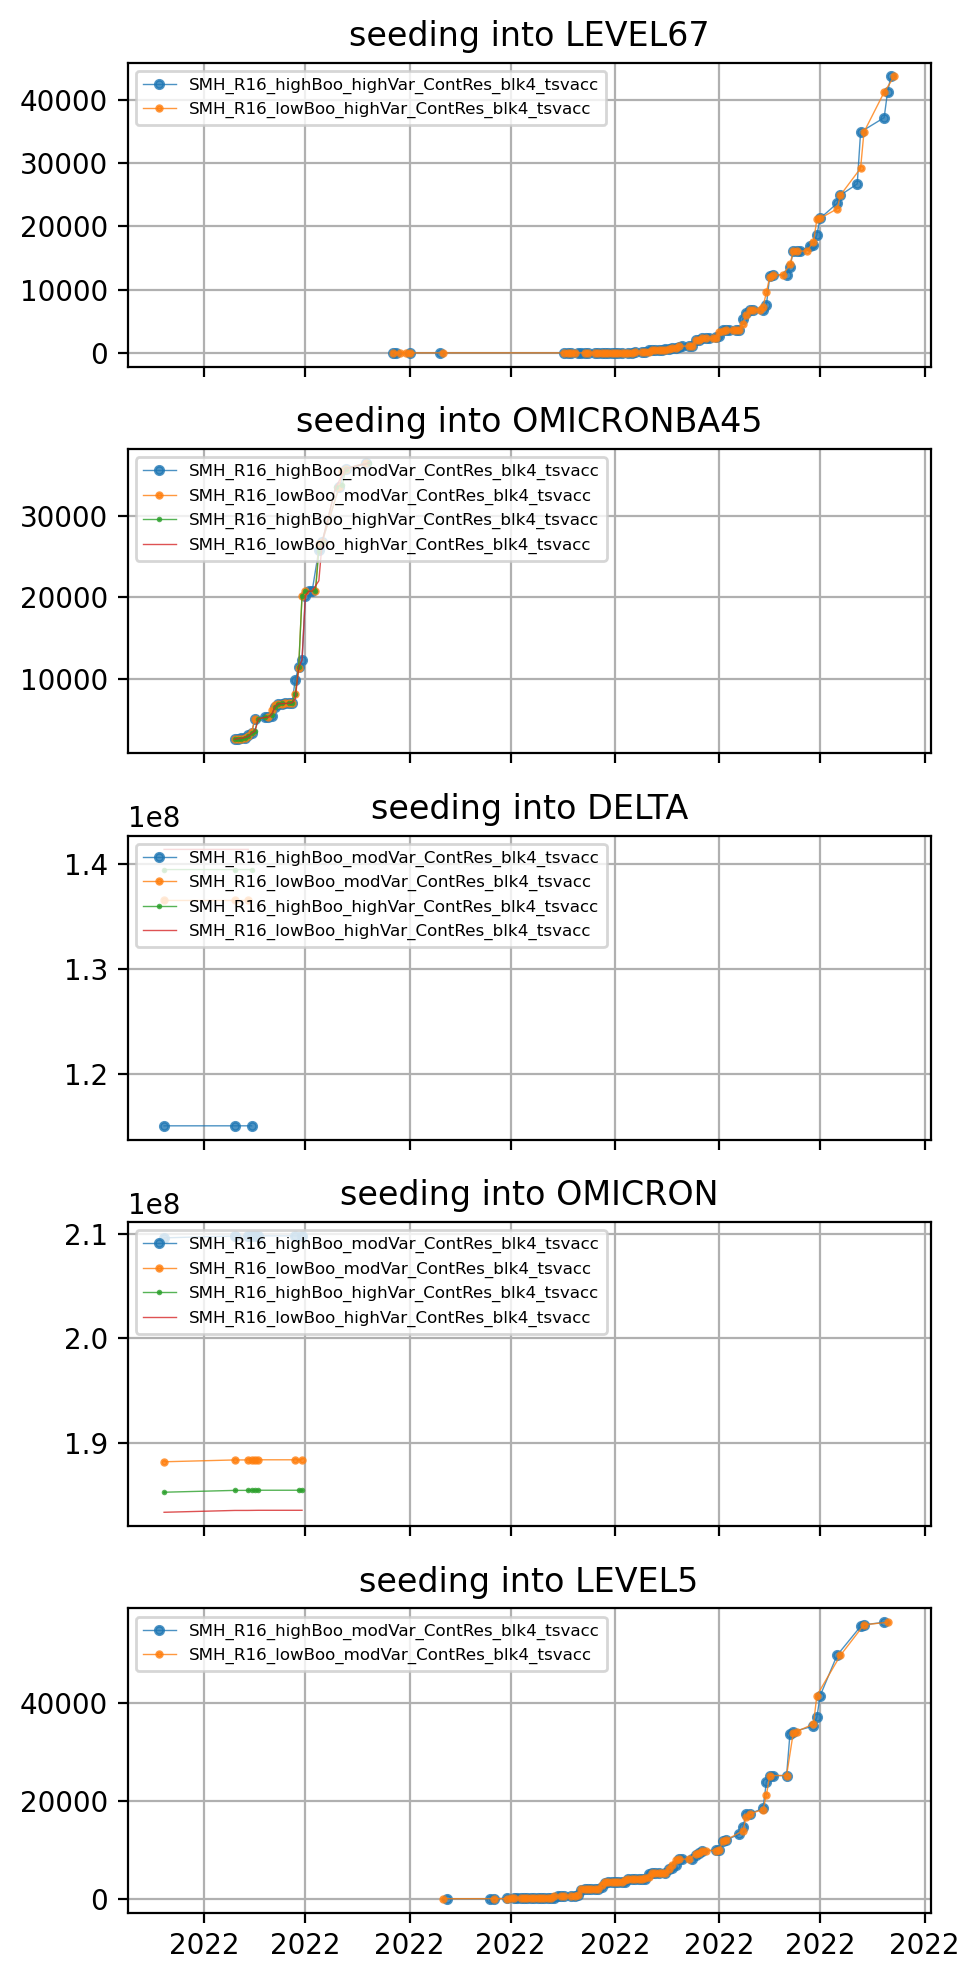

In [148]:
fig, axes = plt.subplots(5, 1, figsize=(5, 10), dpi=200, sharex=True)

for i, var in enumerate(unique_vars): 
    ax = axes.flat[i]
    ax.grid()
    ax.set_title(f"seeding into {var}")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    lw = 2.5
    markersize=8
    for key, fn in seed_files.items():
        df = gempyor.read_df(fn[0])
        df['date'] = pd.to_datetime(df['date']).dt.floor('d') # allow to group same day together
        df = df[df["destination_variant_type"] == var] # .pivot(index = "date", values = "amount", columns="place")
        #ax.plot(df.groupby(["place", "date"]).sum().reset_index().pivot(index = "date", values = "amount", columns="place").sum(axis=1).sort_index(), label = key)
        df = df.groupby(["place", "date"]).sum().reset_index().pivot(index = "date", values = "amount", columns="place").sum(axis=1).sort_index()
        if len(df) > 0:
            lw-=0.5
            markersize -=2
            ax.plot(df.astype(float).index, df.astype(float).cumsum(), label=key, lw=.5, marker='.', markersize=markersize, alpha=.8)
    ax.legend(loc=2, prop={'size': 6})
        
fig.tight_layout()
plt.savefig('seeding_compare.pdf')

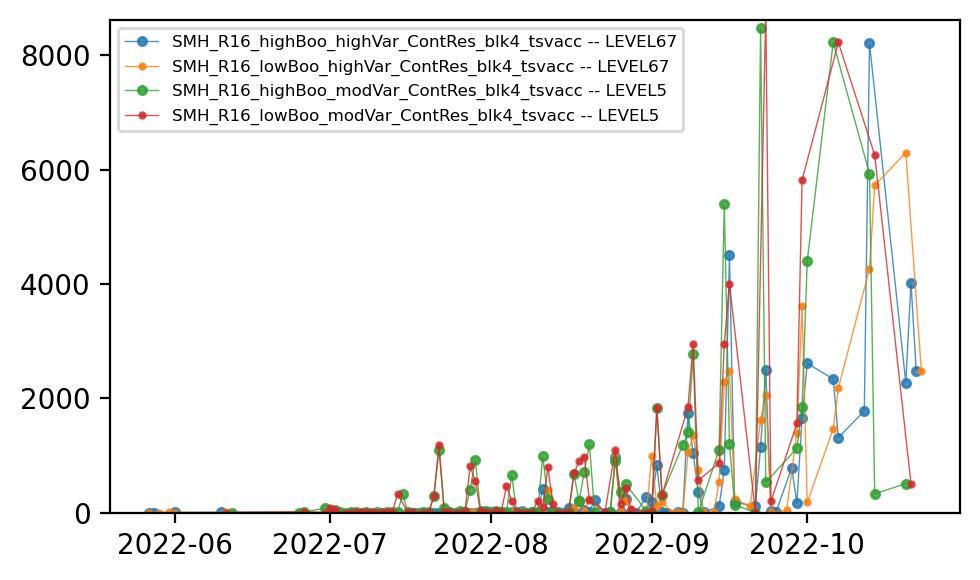

In [159]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3), dpi=200, sharex=True)

for i, var in enumerate([v for v in unique_vars if "LEVEL" in v]): 
    ax = axes
    ax.grid()
    #ax.set_title(f"seeding into {var}")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    lw = 2.5
    markersize=8
    for key, fn in seed_files.items():
        df = gempyor.read_df(fn[0])
        df['date'] = pd.to_datetime(df['date']).dt.floor('d') # allow to group same day together
        df = df[df["destination_variant_type"] == var] # .pivot(index = "date", values = "amount", columns="place")
        #ax.plot(df.groupby(["place", "date"]).sum().reset_index().pivot(index = "date", values = "amount", columns="place").sum(axis=1).sort_index(), label = key)
        df = df.groupby(["place", "date"]).sum().reset_index().pivot(index = "date", values = "amount", columns="place").sum(axis=1).sort_index()
        if len(df) > 0:
            lw-=0.5
            markersize -=2
            ax.plot(df.astype(float).index, df.astype(float), label=f"{key} -- {var}", lw=.5, marker='.', markersize=markersize, alpha=.8)
    ax.legend(loc=2, prop={'size': 6})
    ax.set_ylim(0)
fig.tight_layout()
plt.savefig('seeding_compare.pdf')


In [146]:
df.index

DatetimeIndex(['2022-06-12', '2022-06-25', '2022-06-26', '2022-06-30',
               '2022-07-02', '2022-07-03', '2022-07-04', '2022-07-05',
               '2022-07-06', '2022-07-07', '2022-07-08', '2022-07-09',
               '2022-07-10', '2022-07-11', '2022-07-12', '2022-07-13',
               '2022-07-14', '2022-07-15', '2022-07-16', '2022-07-17',
               '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
               '2022-07-23', '2022-07-24', '2022-07-25', '2022-07-26',
               '2022-07-27', '2022-07-28', '2022-07-29', '2022-07-30',
               '2022-07-31', '2022-08-01', '2022-08-02', '2022-08-03',
               '2022-08-04', '2022-08-05', '2022-08-06', '2022-08-07',
               '2022-08-08', '2022-08-09', '2022-08-10', '2022-08-11',
               '2022-08-12', '2022-08-13', '2022-08-14', '2022-08-16',
               '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-20',
               '2022-08-21', '2022-08-24', '2022-08-25', '2022-08-26',
      

In [144]:
df.index.unique()

DatetimeIndex(['2022-06-12 00:00:26', '2022-06-25 23:59:49',
               '2022-06-26 00:00:04', '2022-06-30 00:00:10',
               '2022-06-30 23:59:22', '2022-07-02 23:59:17',
               '2022-07-03 00:00:06', '2022-07-03 23:59:52',
               '2022-07-04 23:59:45', '2022-07-05 23:59:37',
               ...
               '2022-09-30 00:00:32', '2022-09-30 23:59:58',
               '2022-10-01 00:00:14', '2022-10-06 23:59:25',
               '2022-10-06 23:59:38', '2022-10-06 23:59:46',
               '2022-10-06 23:59:51', '2022-10-13 23:59:42',
               '2022-10-14 00:00:07', '2022-10-20 23:59:30'],
              dtype='datetime64[ns]', name='date', length=222, freq=None)

## Analyse parameters from config
- assume we have the same parameters, no matching per name

In [21]:
for run_name, run_info in all_runs.items():
    config.read(user=False)
    config.set_file(run_info.config_path)

    run_info.gempyor_simulator.get_seir_npi()
    try:  ## this will fail because of seeding but populate gempyor_simulator.debug_parsed_parameters
        run_info.gempyor_simulator.one_simulation(sim_id2write=10, load_ID=False, sim_id2load=5)
    except FileNotFoundError:
        pass

INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.parameters] completed in 0.02 s
INFO:root:[onerun_SEIR.seeding] completed in 0.00 s
INFO:root:[>>> GEMPYOR onesim (from config)] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.parameters] completed in 0.01 s
INFO:root:[onerun_SEIR.seeding] completed in 0.00 s
INFO:root:[>>> GEMPYOR onesim (from config)] completed in 0.09 s


In [ ]:
#out_df = gempyor_simulator.debug_out_df

In [22]:
len(run_info.gempyor_simulator.unique_strings)

33

In [27]:
unique_str = all_runs[list(all_runs.keys())[0]].gempyor_simulator.unique_strings
gempyor_simulator =  all_runs[list(all_runs.keys())[0]].gempyor_simulator # default, for ti, etc

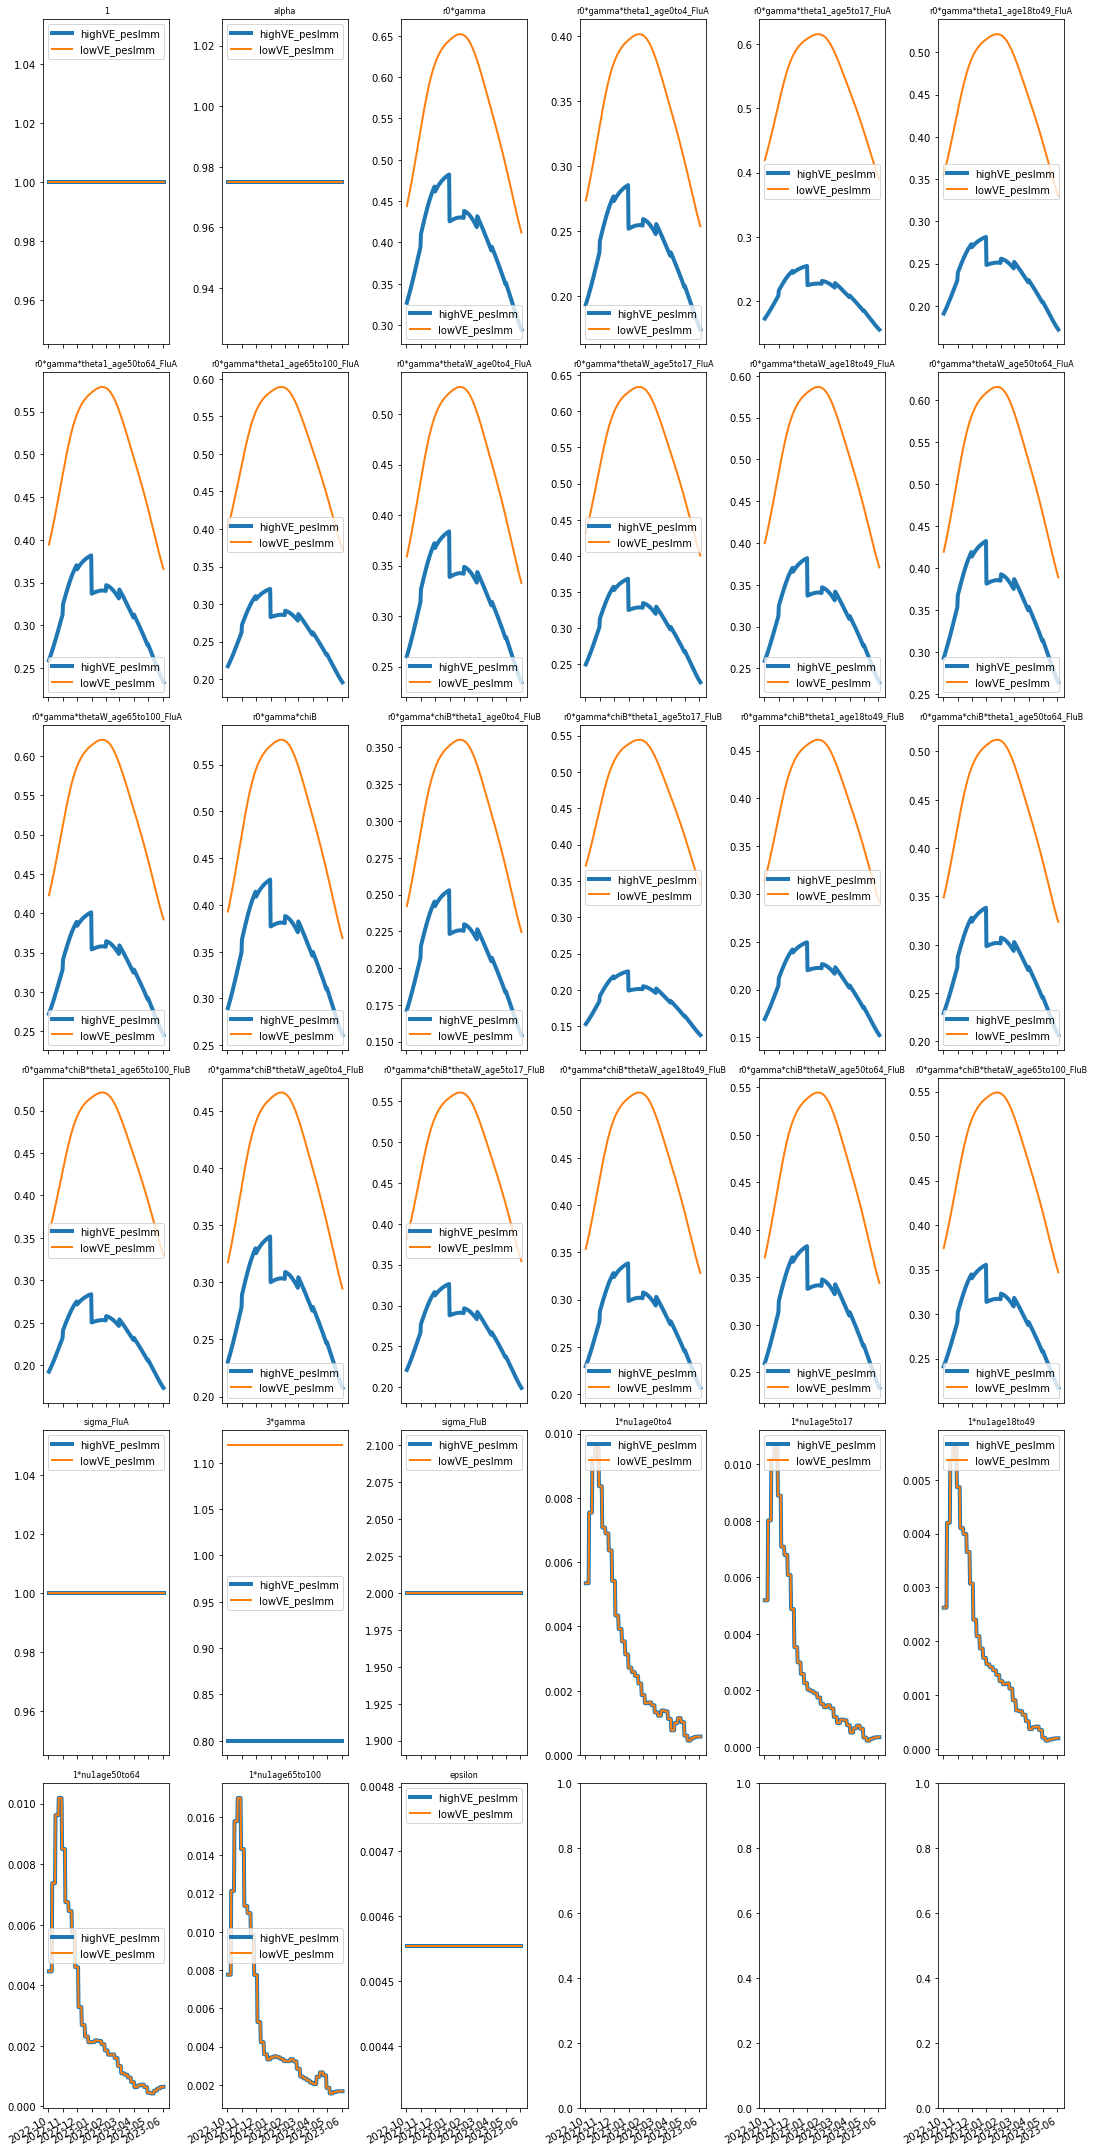

In [39]:
fig, axes = plt.subplots(int(np.sqrt(len(unique_str)))+1, 
                         int(np.sqrt(len(unique_str)))+1, 
                         figsize=(15, 30), 
                         sharex=True)

lw = 4

# assumes the parameters are in the same order, but not necessaraly that htey have the same name.
for run_name, run_info in all_runs.items():
    parsed_parameters = run_info.gempyor_simulator.debug_parsed_parameters
    for k, uniq_pname in enumerate(unique_str):
        ax = axes.flat[k]
        ax.set_title(uniq_pname, fontdict={'size':8})
        df = pd.DataFrame(parsed_parameters[k,:].mean(axis=1), index=pd.date_range(gempyor_simulator.s.ti, gempyor_simulator.s.tf, freq="D"))
        ax.plot(df, label=run_name, lw =lw)
        ax.legend()
    ax.grid()
    lw = lw-2

fig.autofmt_xdate()
fig.tight_layout()
plt.savefig("all_parameters.pdf")

In [ ]:
pdf = PdfPages(f'Unique Parsed Parameter taking just nu for {config_filepath[:-4]}.pdf')
d = pdf.infodict()
d["Title"] = "parsed parameters"
d["Author"] = "jlemaitre"

for k,uniq_pname in enumerate(gempyor_simulator.unique_strings):
    if 'nu' in uniq_pname:
        fig, axes = plt.subplots(7, 8, figsize=(20, 30), sharex=True, sharey=True)
        fig.suptitle(uniq_pname, fontsize=22)
        print(uniq_pname)
        for i, geoid in enumerate(gempyor_simulator.s.spatset.nodenames):
            ax = axes.flat[i]
            ax.set_title(geoid)
            ax.grid()
            df = pd.DataFrame(parsed_parameters[k,:,i], index=pd.date_range(gempyor_simulator.s.ti, gempyor_simulator.s.tf, freq="D"))
            ax.plot(df[:'2021-12-31'])
            fig.autofmt_xdate()
        fig.tight_layout()
        pdf.savefig(fig)
pdf.close()

## Build it step by step

In [ ]:
npi_seir = gempyor_simulator.get_seir_npi(load_ID=True, sim_id2load=0)

In [ ]:

params_draw_arr = gempyor_simulator.get_seir_parameters(load_ID=True, sim_id2load=0)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_spar_df>) or (bypass_FN=<some_spar_filename>)
parameters = gempyor_simulator.get_seir_parameter_reduced(npi_seir=npi_seir, p_draw=params_draw_arr)  # this is a df. TODO: make it also as.df as option
parameters =  gempyor_simulator.s.parameters.parameters_reduce(params_draw_arr, npi_seir)
parsed_parameters = gempyor_simulator.s.compartments.parse_parameters(
                    parameters, gempyor_simulator.s.parameters.pnames, gempyor_simulator.unique_strings
                )

In [ ]:
outcomes = gempyor.read_df('model_output/hosp/USA/inference/med/2022.06.21.14:47:23.UTC/global/intermediate/000000001.000000000.2022.06.21.14:47:23.UTC.hosp.parquet')

In [ ]:
outcomes[['date', 'geoid', 'incidC']].pivot(index='date', columns='geoid', values='incidC').plot(subplots=True, figsize=(5,30));

In [ ]:
outcomes[['date', 'geoid', 'incidD']].pivot(index='date', columns='geoid', values='incidD').plot(subplots=True, figsize=(5,30));

In [ ]:
setup= gempyor_simulator.s
sim_id=0
seeding = pd.read_csv(
                setup.get_input_filename(
                    ftype=setup.seeding_config["seeding_file_type"],
                    sim_id=sim_id,
                    extension_override="csv",
                ),
                converters={"place": lambda x: str(x)},
                parse_dates=["date"],
            )
amounts = seeding["amount"]
seeding = seeding.sort_values(by="date", axis="index").reset_index()
amounts


In [ ]:
seeding_dict, seeding_amounts = gempyor.seeding_ic._DataFrame2NumbaDict(df=seeding, amounts=amounts, setup=setup)

In [ ]:
gempyor_simulator.plot_transition_graph(
    output_file="readable_graph",
    source_filters=[["age0to17"], ["OMICRON", "WILD"]],
    destination_filters=[["OMICRON", "WILD"]],
)

In [ ]:
gempyor_simulator.plot_transition_graph(output_file="full_graph")

In [ ]:
gempyor_simulator.one_simulation(sim_id2write=6, load_ID=True, sim_id2load=5)

In [ ]:
gempyor_simulator.get_seir_npi()

```python
npi_seir = (
    gempyor_simulator.get_seir_npi()
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_snpi_df>) or (bypass_FN=<some_snpi_filename>)
npi_outcome = (
    gempyor_simulator.get_outcome_npi()
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_hnpi_df>) or (bypass_FN=<some_hnpi_filename>)
params_draw_df = (
    gempyor_simulator.get_seir_parametersDF()
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_spar_df>) or (bypass_FN=<some_spar_filename>)
params_draw_arr = (
    gempyor_simulator.get_seir_parameters()
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_spar_df>) or (bypass_FN=<some_spar_filename>)
param_reduc = gempyor_simulator.get_seir_parameter_reduced(
    npi_seir=npi_seir
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_spar_df>) or (bypass_FN=<some_spar_filename>)
param_reduc_from = gempyor_simulator.get_seir_parameter_reduced(
    npi_seir=npi_seir, p_draw=params_draw_arr
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_spar_df>) or (bypass_FN=<some_spar_filename>)
```

In [ ]:
npi_outcome = gempyor_simulator.get_outcome_npi(bypass_FN=fn)

## Compare with FCH


In [2]:
gempyor_simulator_alt = gempyor.InferenceSimulator(
    config_path="config_FCH_R13_pessWan_noVar_blk5_rk4_Jul3.yml",
    run_id="FCH_R13_pessWan_noVar_blk5_rk4_Jul3",
    prefix="USA/inference/med/FCH_R13_pessWan_noVar_blk5_rk4_Jul3/global/intermediate/000000001.",
    first_sim_index=1,
    scenario="inference",  # NPIs scenario to use
    deathrate="med",  # Outcome scenario to use
    stoch_traj_flag=False,
    spatial_path_prefix="./",  # prefix where to find the folder indicated in spatial_setup$
)

  gempyor >> Running ***DETERMINISTIC*** simulation;
  gempyor >> Setup USA_inference; index: 1; run_id: FCH_R13_pessWan_noVar_blk5_rk4_Jul3,
  gempyor >> prefix: USA/inference/med/FCH_R13_pessWan_noVar_blk5_rk4_Jul3/global/intermediate/000000001.;


-102354456.97281416 -101842251.234276


In [3]:
print(f"FCH: llik from {gempyor_simulator_alt.s.read_simID(ftype='llik', sim_id=1).ll.sum():.10} to {gempyor_simulator_alt.s.read_simID(ftype='llik', sim_id=2).ll.sum():.10} in 100 sims")
print(f"SMH: llik from {gempyor_simulator.s.read_simID(ftype='llik', sim_id=1).ll.sum():.10} to {gempyor_simulator.s.read_simID(ftype='llik', sim_id=5).ll.sum():.10} in 250 sims")

FCH: llik from -102354457.0 to -101842251.2 in 100 sims
SMH: llik from -434284079.2 to -335088237.8 in 250 sims


In [8]:
gempyor_simulator_alt.s.read_simID(ftype='llik', sim_id=1)

ll                                           filename  geoid  \
0  -1.007941e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  01000   
1  -2.699470e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  02000   
2  -2.709728e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  04000   
3  -7.981336e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  05000   
4  -1.016942e+07  model_output/llik/USA/inference/med/FCH_R13_pe...  06000   
5  -1.706134e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  08000   
6  -1.351136e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  09000   
7  -3.028198e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  10000   
8  -2.114849e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  11000   
9  -5.995409e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  12000   
10 -3.836466e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  13000   
11 -3.545795e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  15000   
12 -4.727067e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  16000   
13 -3.120461e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  17000   
14 -1.533644e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  18000   
15 -6.884395e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  19000   
16 -4.472809e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  20000   
17 -1.495733e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  21000   
18 -1.072133e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  22000   
19 -5.054004e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  23000   
20 -2.685335e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  24000   
21 -3.081341e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  25000   
22 -3.929505e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  26000   
23 -1.921153e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  27000   
24 -7.257968e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  28000   
25 -1.636314e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  29000   
26 -4.434406e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  30000   
27 -5.570520e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  31000   
28 -7.427291e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  32000   
29 -3.307972e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  33000   
30 -2.127051e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  34000   
31 -5.108601e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  35000   
32 -9.296465e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  36000   
33 -4.576976e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  37000   
34 -2.308779e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  38000   
35 -2.896139e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  39000   
36 -1.110638e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  40000   
37 -9.836471e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  41000   
38 -3.957399e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  42000   
39 -4.578218e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  44000   
40 -1.933882e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  45000   
41 -2.731414e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  46000   
42 -2.365954e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  47000   
43 -7.956162e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  48000   
44 -1.049522e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  49000   
45 -1.293303e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  50000   
46 -2.200219e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  51000   
47 -2.211884e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  53000   
48 -4.960174e+05  model_output/llik/USA/inference/med/FCH_R13_pe...  54000   
49 -3.300712e+06  model_output/llik/USA/inference/med/FCH_R13_pe...  55000   
50 -1.872935e+05  model_output/llik/

In [103]:
seed_fch = gempyor_simulator_alt.s.read_simID(ftype='seed', sim_id=2,  extension_override='csv')
seed_smh = gempyor_simulator.s.read_simID(ftype='seed', sim_id=5,  extension_override='csv')

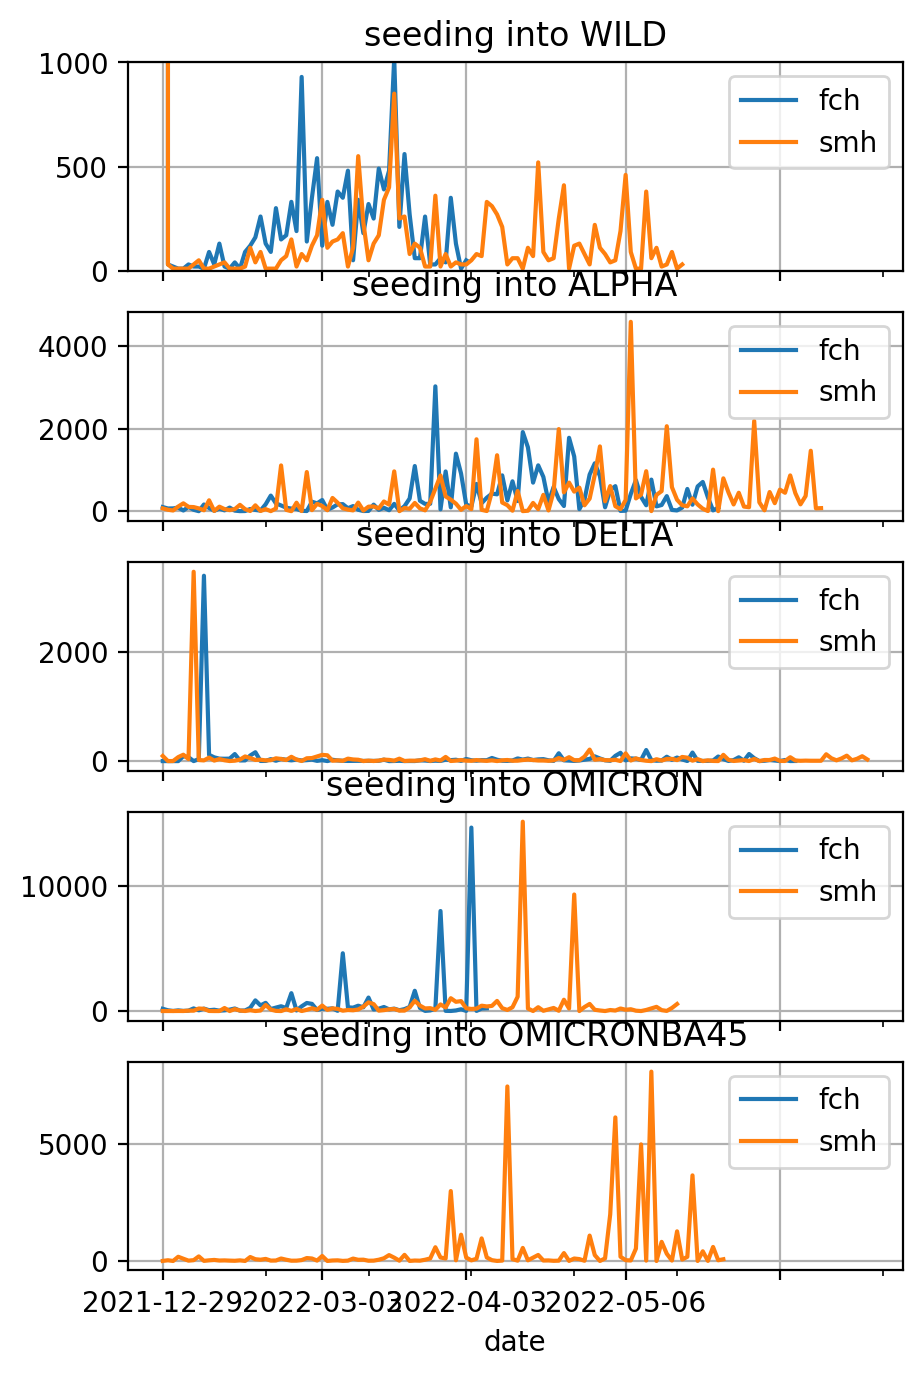

In [160]:
dt = {'fch': seed_fch, 'smh': seed_smh}
fig, axes = plt.subplots(5, 1, figsize=(5, 8), dpi=200, sharex=True)

for i, var in enumerate(seed_smh["destination_variant_type"].unique()): 
    ax = axes.flat[i]
    for key, df in dt.items():
        df = df[df["destination_variant_type"] == var] # .pivot(index = "date", values = "amount", columns="place")
        #ax.plot(df.groupby(["place", "date"]).sum().reset_index().pivot(index = "date", values = "amount", columns="place").sum(axis=1).sort_index(), label = key)
        df.groupby(["place", "date"]).sum().reset_index().pivot(index = "date", values = "amount", columns="place").sum(axis=1).sort_index().plot(ax=ax, label=key)
        ax.legend()
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.grid()
        if var == 'WILD': ax.set_ylim(0,1000)
        ax.set_title(f"seeding into {var}")
plt.savefig('seeding_compare.pdf')

In [167]:

gempyor_simulator_altw = gempyor.InferenceSimulator(
    config_path="config_FCH_R13_pessWan_noVar_blk5_rk4_Jun12.yml",
    run_id="FCH_R13_pessWan_noVar_blk5_rk4_Jun12",
    prefix="USA/inference/med/FCH_R13_pessWan_noVar_blk5_rk4_Jun12/global/intermediate/000000001.",
    first_sim_index=1,
    scenario="inference",  # NPIs scenario to use
    deathrate="med",  # Outcome scenario to use
    stoch_traj_flag=False,
    spatial_path_prefix="./",  # prefix where to find the folder indicated in spatial_setup$
)
gp = {'fch': gempyor_simulator_alt, 'smh': gempyor_simulator, 'fch_from': gempyor_simulator_altw}

  gempyor >> Running ***DETERMINISTIC*** simulation;
  gempyor >> Setup USA_inference; index: 1; run_id: FCH_R13_pessWan_noVar_blk5_rk4_Jun12,
  gempyor >> prefix: USA/inference/med/FCH_R13_pessWan_noVar_blk5_rk4_Jun12/global/intermediate/000000001.;


In [ ]:
config_filepath = "config_SMH_R14_restBoo_noVar_blk5.yml"
config.clear()
config.read(user=False)
config.set_file(config_filepath)
gp['smh'].one_simulation(sim_id2write=10, load_ID=True, sim_id2load=1)

config_filepath = "config_FCH_R13_pessWan_noVar_blk5_rk4_Jun12.yml"
config.clear()
config.read(user=False)
config.set_file(config_filepath)
gp['fch_from'].one_simulation(sim_id2write=10, load_ID=True, sim_id2load=2)


config_filepath = "config_FCH_R13_pessWan_noVar_blk5_rk4_Jul3.yml"
config.clear()
config.read(user=False)
config.set_file(config_filepath)
gp['fch'].one_simulation(sim_id2write=10, load_ID=True, sim_id2load=2)

In [210]:
config_filepath = "config_SMH_R14_restBoo_noVar_blk5.yml"
config.clear()
config.read(user=False)
config.set_file(config_filepath)
gp['smh'].one_simulation(sim_id2write=10, load_ID=True, sim_id2load=1)

INFO:root:[SEIR.NPI] completed in 54.14 s
INFO:root:[Outcomes.NPI] completed in 1.14 s
INFO:root:[onerun_SEIR.seeding] completed in 3.75 s
INFO:root:[SEIR.parameters] completed in 0.20 s
INFO:root:Integrating with method rk4.jit
625it [02:02,  5.12it/s]
INFO:root:[SEIR.compute] completed in 124.11 s
INFO:root:[SEIR.postprocess] completed in 6.25 s
/Users/chadi/opt/miniconda3/envs/covidSProd6/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
INFO:root:[onerun_delayframe_outcomes.compute] completed in 89.39 s
/Users/chadi/Documents/phd/COVIDScenarioPipeline/COVIDScenarioPipeline/gempyor_pkg/src/gempyor/outcomes.py:321: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

0

In [171]:
gsf = gp['fch_from']
gss = gp['smh']

In [201]:
from collections import Counter


In [202]:
print('_'*100)
print('_'*100)
print('_'*100)
onlyingsf = list((Counter(gsf.debug_npi_outcomes.getReductionDF()['npi_name'].to_list())-Counter(gss.debug_npi_outcomes.getReductionDF()['npi_name'].to_list())).elements())
onlyingss = list((Counter(gss.debug_npi_outcomes.getReductionDF()['npi_name'].to_list())-Counter(gsf.debug_npi_outcomes.getReductionDF()['npi_name'].to_list())).elements())
print(f"Outcomes_NPIs ONLY IN FCH12Jun: {onlyingsf}")
print('_'*100)
print(f"Outcomes_NPIs ONLY IN SMH: {onlyingss}")

____________________________________________________________________________________________________
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Outcomes_NPIs ONLY IN FCH12Jun: ['AL_incidCshift1_R13', 'AL_incidCshift2_R13', 'AL_incidCshift_vacc_R13', 'AL_incidCshift_delta_R13', 'AL_incidCshiftOm_R13', 'AK_incidCshift_R13', 'AK_incidCshift_vacc_R13', 'AK_incidCshift_delta_R13', 'AK_incidCshiftOm_R13', 'AZ_incidCshift1_R13', 'AZ_incidCshift2_R13', 'AZ_incidCshift_vacc_R13', 'AZ_incidCshift_delta_R13', 'AZ_incidCshiftOm_R13', 'AR_incidCshift_R13', 'AR_incidCshift_vacc_R13', 'AR_incidCshift_delta_R13', 'AR_incidCshiftOm_R13', 'CA_incidCshift1_R13', 'CA_incidCshift2_R13', 'CA_incidCshift_vacc_R13', 'CA_incidCshift_delta_R13', 'CA_incidCshiftOm_R13', 'CO_incidCshift1_R13', 'CO_incidCshift2_R13', 'CO_incidCshift_vacc_R13', 'CO_incidCshif

In [197]:
print('_'*100)
print('_'*100)
print('_'*100)
onlyingsf = list((Counter(gsf.s.parameters.pnames)-Counter(gss.s.parameters.pnames)).elements())
onlyingss = list((Counter(gss.s.parameters.pnames)-Counter(gsf.s.parameters.pnames)).elements())
print(f"SEIR_parameters ONLY IN FCH12Jun: {onlyingsf}")
print('_'*100)
print(f"SEIR_parameters ONLY IN SMH: {onlyingss}")

____________________________________________________________________________________________________
SEIR_parameters ONLY IN FCH12Jun: ['sigma_R13', 'sigma_delta_R13', 'sigma_omicron_R13', 'alpha_R13', 'r0_R13', 'gamma_R13', 'epsilon_R13', 'chi1_R13', 'chi2_R13', 'chi3_R13', 'theta1_WILD_R13', 'theta2_WILD_R13', 'theta1_ALPHA_R13', 'theta2_ALPHA_R13', 'theta1_DELTA_R13', 'theta2_DELTA_R13', 'theta1_OMICRON_R13', 'theta2_OMICRON_R13', 'thetaEsc_OMICRON_R13', 'thetaW_OMICRON_R13', 'thetaW1_OMICRON_R13', 'nu1age0to17_R13', 'nu3age0to17_R13', 'nu1age18to64_R13', 'nu3age18to64_R13', 'nu1age65to100_R13', 'nu3age65to100_R13', 'nu2_R13']
____________________________________________________________________________________________________
SEIR_parameters ONLY IN SMH: ['sigma_R14', 'sigma_delta_R14', 'sigma_omicron_R14', 'alpha_R14', 'r0_R14', 'gamma_R14', 'epsilon_R14', 'chi1_R14', 'chi2_R14', 'chi3_R14', 'thetaW_WILD_WILD_R14', 'thetaW_WILD_ALPHA_R14', 'thetaW_WILD_DELTA_R14', 'theta_WILD_OMICR

In [208]:
onlyingsf = list((Counter(gsf.debug_hpar_df['outcome'].to_list())-Counter(gss.debug_hpar_df['outcome'].to_list())).elements())
onlyingss = list((Counter(gss.debug_hpar_df['outcome'].to_list())-Counter(gsf.debug_hpar_df['outcome'].to_list())).elements())
onlyingsf = [a for a in onlyingsf if 'R13' not in a]
onlyingss = [a for a in onlyingss if 'R14' not in a]
print(f"outcomes_parameters ONLY IN FCH12Jun, FILTERED FOR R13: {onlyingsf}")
print('_'*100)
print(f"outcomes_parameters ONLY IN SMH, FILTERED FOR R14: {onlyingss}")

outcomes_parameters ONLY IN FCH12Jun, FILTERED FOR R13: []
____________________________________________________________________________________________________
outcomes_parameters ONLY IN SMH, FILTERED FOR R14: []


In [207]:
print('_'*100)
print('_'*100)
print('_'*100)
onlyingsf = list((Counter(gsf.debug_npi_seir.getReductionDF()['npi_name'].to_list())-Counter(gss.debug_npi_seir.getReductionDF()['npi_name'].to_list())).elements())
onlyingss = list((Counter(gss.debug_npi_seir.getReductionDF()['npi_name'].to_list())-Counter(gsf.debug_npi_seir.getReductionDF()['npi_name'].to_list())).elements())
onlyingsf = [a for a in onlyingsf if 'R13' not in a]
onlyingss = [a for a in onlyingss if 'R14' not in a]
print(f"SEIR_NPIs ONLY IN FCH12Jun, FILTERED FOR R13: {onlyingsf}")
print('_'*100)
print(f"SEIR_NPIs ONLY IN SMH, FILTERED FOR R14: {onlyingss}")

____________________________________________________________________________________________________
____________________________________________________________________________________________________
____________________________________________________________________________________________________
SEIR_NPIs ONLY IN FCH12Jun: ['FL_open_p4A', 'FL_open_p5A', 'FL_open_p6A', 'FL_open_p7A']
____________________________________________________________________________________________________
SEIR_NPIs ONLY IN SMH: ['summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'summer', 'su

yes 1
yes alpha_R14
yes r0_R14*gamma_R14
yes r0_R14*gamma_R14*theta1_WILD_R14
yes r0_R14*gamma_R14*theta2_WILD_R14
yes r0_R14*gamma_R14*chi1_R14
yes r0_R14*gamma_R14*theta1_ALPHA_R14*chi1_R14
yes r0_R14*gamma_R14*theta2_ALPHA_R14*chi1_R14
yes r0_R14*gamma_R14*chi2_R14
yes r0_R14*gamma_R14*theta1_DELTA_R14*chi2_R14
yes r0_R14*gamma_R14*theta2_DELTA_R14*chi2_R14
yes r0_R14*gamma_R14*chi3_R14
yes r0_R14*gamma_R14*theta1_OMICRON_R14*chi3_R14
yes r0_R14*gamma_R14*theta2_OMICRON_R14*chi3_R14
yes sigma_R14
yes 3*gamma_R14
yes sigma_delta_R14
yes sigma_omicron_R14
yes epsilon_R14
yes 1*nu1age0to17_R14
yes 1*nu1age18to64_R14
yes 1*nu1age65to100_R14
yes 1*nu3age0to17_R14
yes 1*nu3age18to64_R14
yes 1*nu3age65to100_R14
yes 1*nu2_R14
yes 1*epsilon_R14


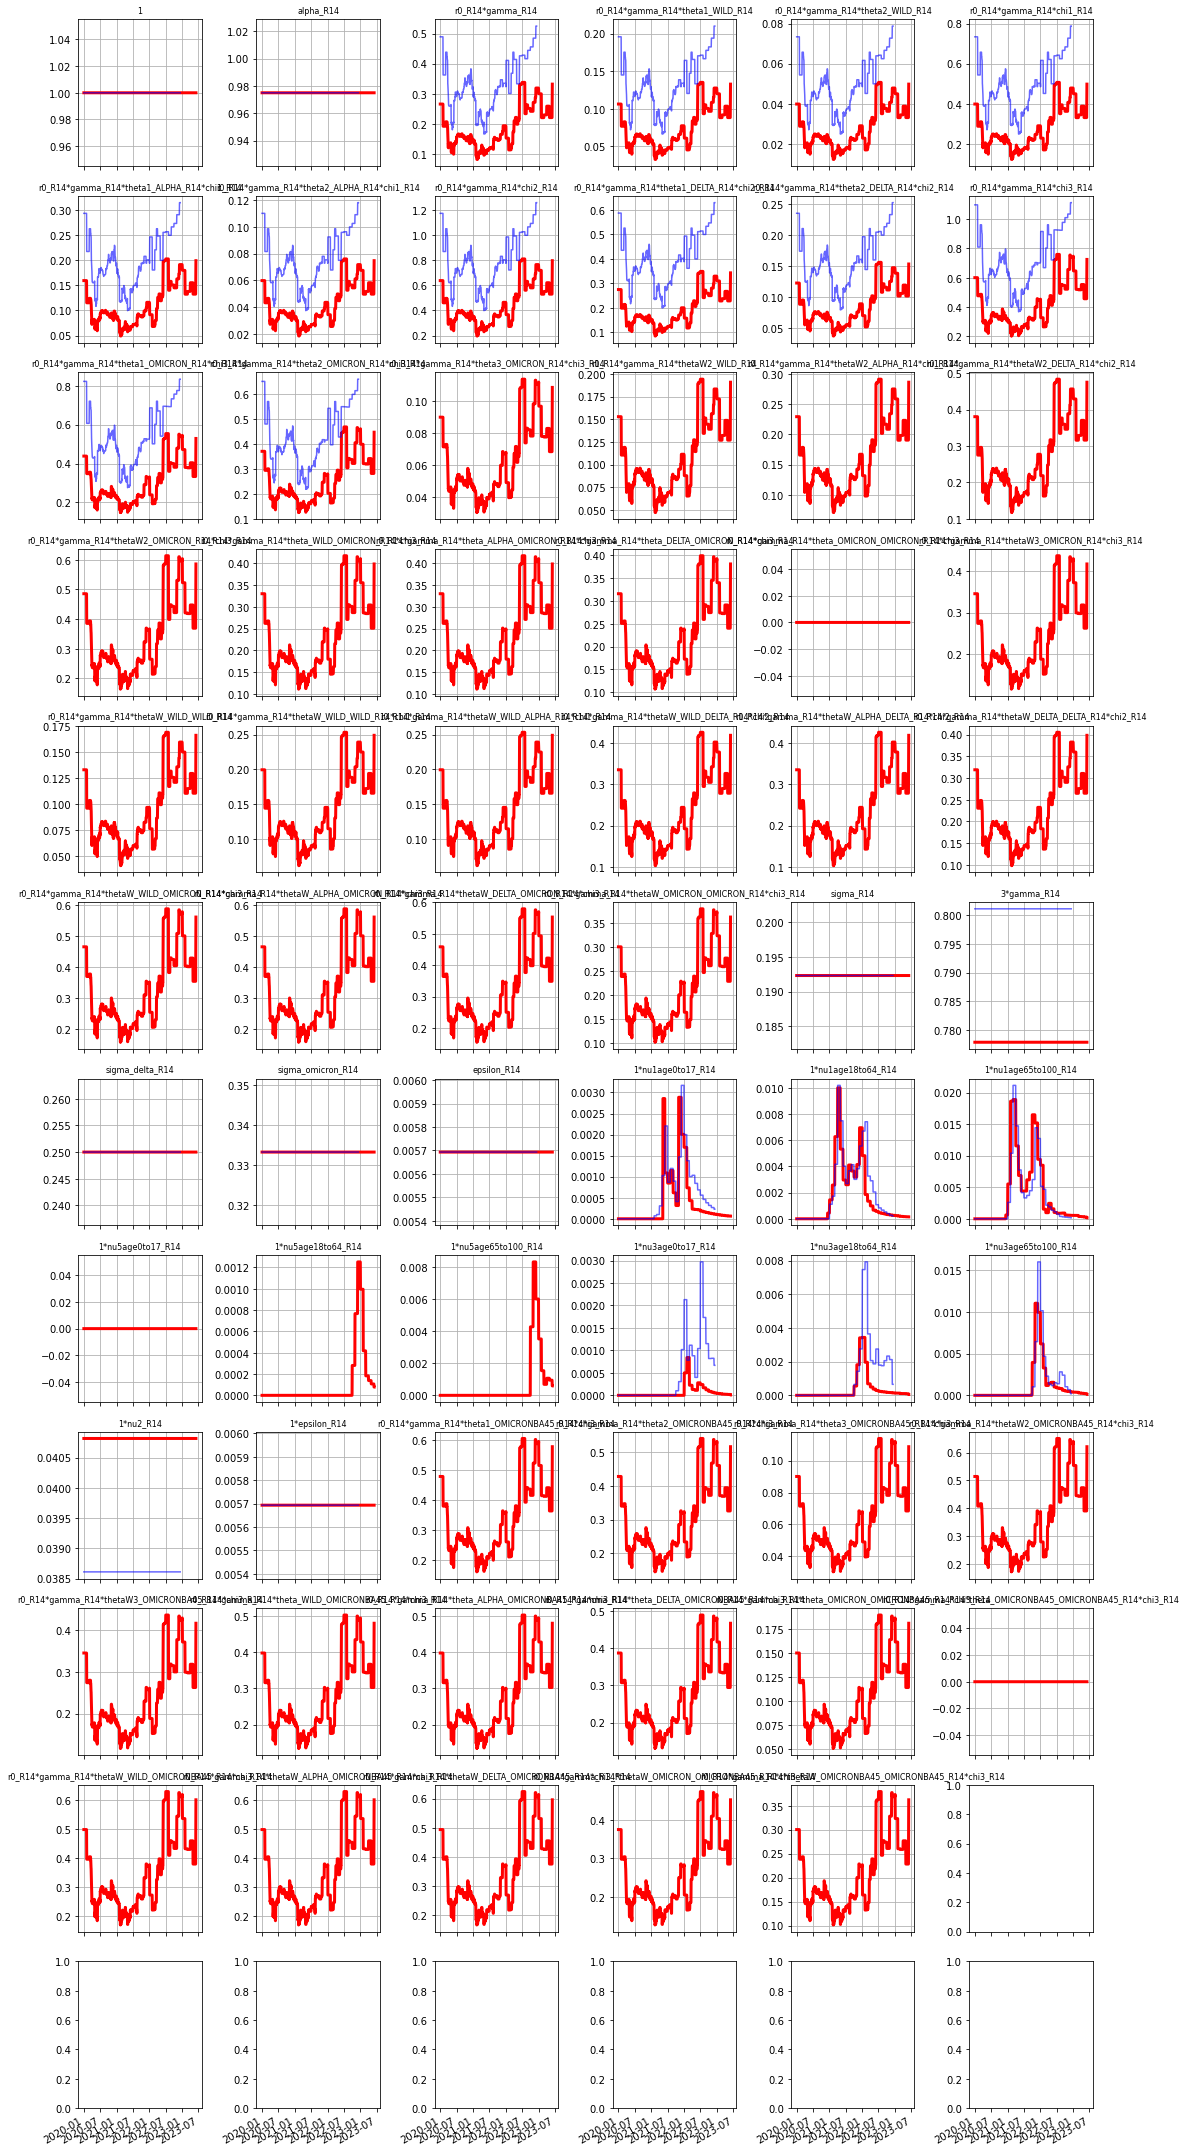

In [224]:
parsed_parametres = gss.debug_parsed_parameters

fig, axes = plt.subplots(12, 6, figsize=(15, 30), sharex=True)

for k, uniq_pname in enumerate(gss.unique_strings):
    ax = axes.flat[k]
    ax.set_title(uniq_pname, fontsize=8)
    ax.grid()
    df = pd.DataFrame(parsed_parameters[k,:].mean(axis=1), index=pd.date_range(gempyor_simulator.s.ti, gempyor_simulator.s.tf, freq="D"))
    ax.plot(df, c = 'r', lw=3)
    if uniq_pname.replace('R14','R13') in gsf.unique_strings:
        print('yes', uniq_pname)
        k = gsf.unique_strings.index(uniq_pname.replace('R14','R13'))
        df = pd.DataFrame(gsf.debug_parsed_parameters[k,:].mean(axis=1), index=pd.date_range(gempyor_simulator_altw.s.ti, gempyor_simulator_altw.s.tf, freq="D"))
        ax.plot(df, c = 'b', alpha=.6)

fig.autofmt_xdate()
fig.tight_layout()
plt.savefig("all_parameters_compare.pdf")

In [229]:
gempyor_simulator.update_prefix(gempyor_simulator_altw.s.in_prefix)
gempyor_simulator.update_run_id(gempyor_simulator_altw.s.in_run_id)
gempyor_simulator.s.ti = gempyor_simulator_altw.s.ti
gempyor_simulator.s.tf = gempyor_simulator_altw.s.tf
outcomes_df1, hpar_df1 = gempyor.outcomes.compute_all_multioutcomes(
                    s=gempyor_simulator.s,
                    sim_id2write=1,
                    parameters=gempyor_simulator.outcomes_parameters,
                    loaded_values=gempyor_simulator.debug_loaded_values,
                    npi=gempyor_simulator.debug_npi_outcomes,
                )

/Users/chadi/opt/miniconda3/envs/covidSProd6/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [230]:
outcomes_df2, hpar_df2 = gempyor.outcomes.compute_all_multioutcomes(
                    s=gempyor_simulator.s,
                    sim_id2write=1,
                    parameters=gempyor_simulator_altw.outcomes_parameters,
                    loaded_values=gempyor_simulator_altw.debug_loaded_values,
                    npi=gempyor_simulator_altw.debug_npi_outcomes,
                )

/Users/chadi/opt/miniconda3/envs/covidSProd6/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


NameError: name 'sim_id' is not defined

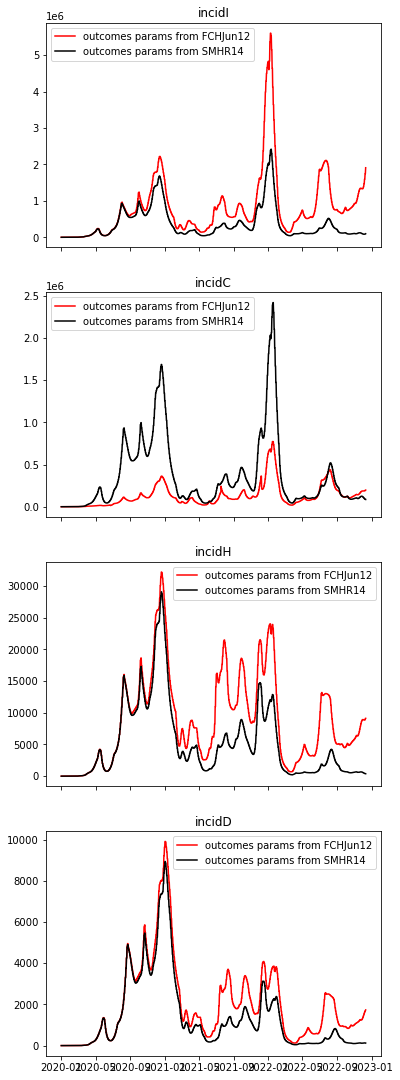

In [246]:

fig, axes = plt.subplots(4,1, figsize=(6, 19), sharex=True)
for i, ot in enumerate(['incidI', 'incidC', 'incidH', 'incidD']):
    ax = axes.flat[i]
    ax.plot(outcomes_df2.groupby('date').sum()[ot], c = 'r', label='outcomes params from FCHJun12')
    ax.plot(outcomes_df1.groupby('date').sum()[ot], c = 'k', label='outcomes params from SMHR14')
    ax.set_title(ot)
    ax.legend()